Setting up a Convolutional Neural Network for image classification with Keras:

Used dataset: Traffic signs: kaggle.com/valentynsichkar/traffic-signs-preprocessed



In [72]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import keras

## Data

In [2]:
#load the data
data = pickle.load(open("data/data0.pickle","rb"))

In [3]:
# the data is a dictionary with the following keys:
# The dataset is already nicely prepared, therefore, no more preparation is needed. Even the splits
# are already done!
data.keys()

dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])

In [4]:
# extract the datasets
x_test = data["x_test"]
y_validation = data["y_validation"]
x_validation = data["x_validation"]
labels = data["labels"]
x_train = data["x_train"]
y_test = data["y_test"]
y_train = data["y_train"]

In [5]:
# delete the now obsolete original dataset
del(data)

In [6]:
# the labels are not yet in a one-hot encoding 
display(y_test[1])

# the labels are integers - therefore, the keras function to_categorical can be used to encode it
from keras.utils import to_categorical

# transformation:
def ohe(labs):
    ohe_labs = to_categorical(labs)
    return ohe_labs
y_test = ohe(y_test)
display(y_test[1])

11

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
# Nice, and the same with the others:
y_validation = ohe(y_validation)
y_train = ohe(y_train)

In [8]:
# the shape of the training data
x_train.shape

(86989, 3, 32, 32)

In [9]:
x_train = np.transpose(x_train/255.,[0,2,3,1])
x_test = np.transpose(x_test/255.,[0,2,3,1])
x_validation = np.transpose(x_validation/255.,[0,2,3,1])

In [10]:
# total number of classes:
len(y_train[1])

43

## Model building

In [20]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout

# Initialize the model object
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(10, kernel_size=3, activation='relu', 
               input_shape=(32,32,3),
                padding = "same"))

model.add(Dropout(0.1))


model.add(Conv2D(10, kernel_size=6, activation='relu'))

model.add(Dropout(0.1))

model.add(Conv2D(10, kernel_size=9, activation='relu'))

# model.add(Conv2D(10, kernel_size=12, activation='relu'))


# Flatten the output of the convolutional layer
model.add(Flatten())
# Add an output layer for the categories
model.add(Dense(43, activation='softmax'))

In [21]:
# Compile the model 
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Fit the model on a training set
model.fit(x_train, y_train, 
          validation_split=0.2, 
          epochs=3, batch_size=100)

Train on 69591 samples, validate on 17398 samples
Epoch 1/3
69591/69591 [==============================] - 389s 6ms/step - loss: 0.6401 - accuracy: 0.8408 - val_loss: 0.1726 - val_accuracy: 0.9619
Epoch 2/3
69591/69591 [==============================] - 371s 5ms/step - loss: 0.1217 - accuracy: 0.9692 - val_loss: 0.0780 - val_accuracy: 0.9803
Epoch 3/3
69591/69591 [==============================] - 387s 6ms/step - loss: 0.0655 - accuracy: 0.9830 - val_loss: 0.0533 - val_accuracy: 0.9866


In [22]:
# evaluate the model:
model.evaluate(x_validation,y_validation)

4410/4410 [==============================] - 6s 1ms/step


[0.3249582879329755, 0.9383220076560974]

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 10)        280       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 10)        3610      
_________________________________________________________________
dropout_7 (Dropout)          (None, 27, 27, 10)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 19, 19, 10)        8110      
_________________________________________________________________
flatten_4 (Flatten)          (None, 3610)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 43)               

In [27]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [46]:
from keras import backend as K

layer_name = 'conv2d_11'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, x_test[0])[0]

# normalization trick: we normalize the gradient
# grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# # this function returns the loss and grads given the input picture
iterate = K.function([x_test[0]], [loss, grads])

In [70]:
model.layers[0].count_params()
def plot_filters(layer,x,y):
    filters = layer.get_weights()
    fig = plt.figure()
    for j in range(len(filters)):
        ax = fig.add_subplot(y,x,j+1)
        ax.matshow(filters[j][0],cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

In [65]:
model.layers[0]

[array([[[[ 0.08688544,  0.10909459, -0.23412396,  0.21183096,
            0.10547269, -0.0264803 , -0.15383878,  0.07359526,
           -0.12880147, -0.07916654],
          [ 0.2341678 , -0.02790572,  0.02290693, -0.04915596,
           -0.05218388,  0.26422137,  0.09890056,  0.21211976,
           -0.34879655, -0.23018491],
          [-0.12738757,  0.13431245,  0.07375569, -0.00381359,
            0.03461976,  0.09506344, -0.19497035,  0.02081761,
           -0.32414344, -0.26140603]],
 
         [[ 0.29828554,  0.21018265, -0.07805371,  0.06431853,
           -0.29928014,  0.18849787, -0.07426607, -0.14944077,
           -0.11906607, -0.05050926],
          [-0.01320164,  0.20758435,  0.20456369, -0.09688693,
           -0.22840014,  0.21220519,  0.14064872, -0.15407656,
            0.08842474, -0.25401226],
          [ 0.07374608,  0.064326  , -0.04071989, -0.27816892,
           -0.27423653,  0.24358882,  0.15861228, -0.15837473,
            0.11902452, -0.17162041]],
 
         [

TypeError: Invalid shape (3, 3, 10) for image data

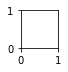

In [79]:
plot_filters(model.layers[0],2,5)